# Softmax exercise

We will implement a softmax classifier that is trained on the CIFAR10 dataset. The output is a model that is able to classify the input image into the 10 different classes of the CIFAR10 dataset.

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- use a validation set to **tune the learning rate** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../data/cifar-10-batches-py'
    X_train, y_train = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Files already downloaded and verified
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **softmax.py**. This is where the method **softmax_loss_vectorized** will be implemented. This method just returns the loss and gradient after applying the softmax function.


In [172]:
from softmax import softmax_loss_vectorized

W = np.random.randn(3073, 10) * 0.0001
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_val, y_val)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


vectorized loss: 2.872308e+00 computed in 0.022496s


## In the file linear_classifier.py, implement SGD in the function LinearClassifier.train() and call this function to do the training.
## Write the LinearSVM.predict() function and call this function to evaluate the performance on both the training and validation set

In [ ]:
# Use the validation set to tune hyperparameters (learning rate). 
# You should experiment with different ranges for the learning
# rates; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from linear_classifier import Softmax

results = {}
best_val = -1
best_softmax = Softmax()
learning_rates = [1e-7, 5e-7]
losses = []

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning.                                  #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################
softmax = Softmax()

def calculate_accuracy(y_pred, y_val):
    return np.mean(y_pred == y_val)

for lr in learning_rates:
    tic = time.time()
    
    loss_history = softmax.train(X_train, y_train, learning_rate = lr, num_iters = 100, batch_size= 200, verbose = True, reg = 1000)
    losses.append(loss_history)
    
    y_val_pred = softmax.predict(X_val)
    y_train_pred = softmax.predict(X_train)
    
    val_acc = calculate_accuracy(y_val_pred, y_val)
    train_acc = calculate_accuracy(y_train_pred, y_train)

    if val_acc > best_val:
        print('Updating best softmax')
        best_val = val_acc
        best_softmax.W = softmax.W.copy()
        
    
    results[lr] = (train_acc, val_acc)
    
    toc = time.time()
    print('\nTraining executed in {}s'.format(toc-tic))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Number of batches:  245
iteration 0 / 100: loss 31.013295
iteration 20 / 100: loss 5.649289
iteration 40 / 100: loss 2.431177
iteration 60 / 100: loss 1.909534
iteration 80 / 100: loss 1.863686
Updating best softmax

Training executed in 47.25552415847778s
Number of batches:  245
iteration 0 / 100: loss 3.543596


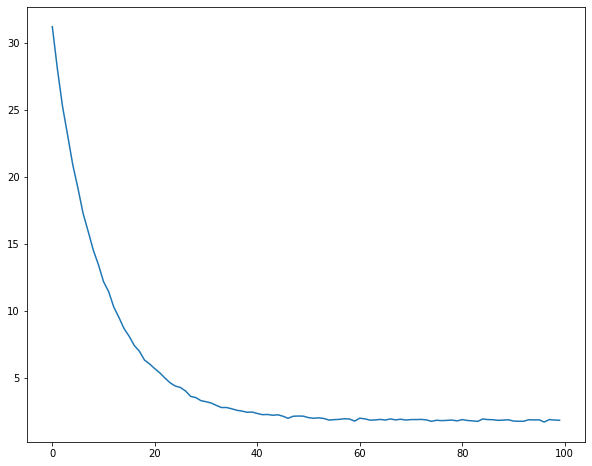

In [158]:
iters = range(100)
f = plt.figure()

plt.plot(iters, losses[0])
plt.title('Training Loss for best model')
plt.xlabel('Iteration')
plt.ylabel()

In [171]:
# evaluate on val set
# Evaluate the best softmax on val set
y_val_pred = best_softmax.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('softmax on raw pixels final test set accuracy: %f' % (val_accuracy, ))


softmax on raw pixels final test set accuracy: 0.404000


dtype('int64')

Save the best_softmax weights using pickle:

In [163]:
with open('softmax_weights.pkl', 'wb') as f:
    pickle.dump(softmax.W, f)

Load the best_softmax weights using pickle:

In [164]:
with open('softmax_weights.pkl', 'rb') as f:
    W = pickle.load(f)
new_softmax = Softmax()
new_softmax.W = W.copy()

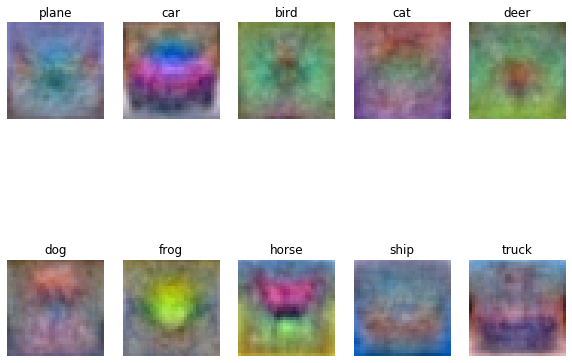

In [165]:
# Visualize the learned weights for each class
w =  new_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])